In [1]:
import numpy as np
from scipy.linalg import expm
from qutip import create, destroy, sigmap, sigmam, tensor, qeye, sigmaz
import matplotlib.pyplot as plt

In [2]:
# Constantes:

N_fotones = 3


P_a = 0
K_a = 0

P_s = 0
Gm_s = 0

g = 25
Gm_d = 0

In [3]:
def pulso_gaussiano(t, omega_0 = 100, a=5, sigma=0.5):
    """
    Simula un pulso gaussiano de la forma:
    Omega(t) = Omega_0 * exp(-0.5 * ((t - a) / sigma)^2)
    
    Parámetros:
    t       -- array de tiempo
    omega_0 -- amplitud máxima del pulso
    a       -- tiempo central del pulso
    sigma   -- ancho del pulso (desviación estándar)
    
    Retorna:
    Pulso gaussiano evaluado en los tiempos t.
    """
    return omega_0 * np.exp(-0.5 * ((t - a) / sigma)**2)

In [4]:
#  omega_0 = 100, a=5, sigma=0.5

In [4]:
def pulso_gaussiano_t(t):
    """
    Simula un pulso gaussiano de la forma:
    Omega(t) = Omega_0 * exp(-0.5 * ((t - a) / sigma)^2)
    
    Parámetros:
    t       -- array de tiempo
    omega_0 -- amplitud máxima del pulso
    a       -- tiempo central del pulso
    sigma   -- ancho del pulso (desviación estándar)
    
    Retorna:
    Pulso gaussiano evaluado en los tiempos t.
    """
    return omega_0 * np.exp(-0.5 * ((t - a) / sigma)**2)

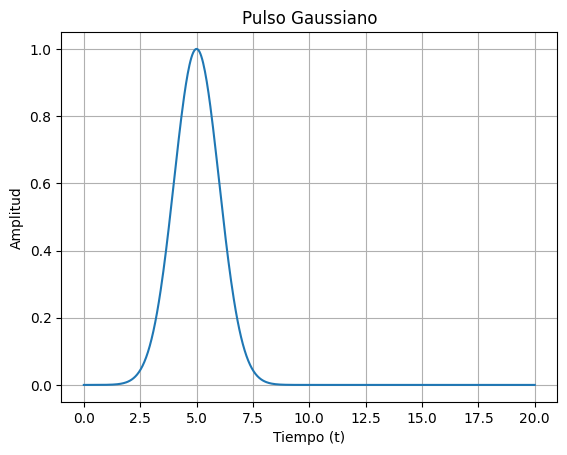

In [5]:
# Parámetros del pulso
omega_0 = 1.0  # Amplitud máxima
a = 5        # Tiempo central del pulso
sigma = 1.0    # Ancho del pulso

# Definir un rango de tiempo
t = np.linspace(0, 20, 500)

# Calcular el pulso gaussiano
pulso = pulso_gaussiano(t, omega_0, a, sigma)

# Graficar el pulso
plt.plot(t, pulso)
plt.title("Pulso Gaussiano")
plt.xlabel("Tiempo (t)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

In [7]:
def H_rot(t, h=1, Delt_a=0.0004, Delt_c=0.0004, g=25, n_fotons=4):
  
  # Pulso del lasser:
  # ===========================
  Omega_t = pulso_gaussiano_t(t)
  
  # Matrices Identidad:
  # ===========================
  I_campo = qeye(n_fotons) # Campo
  I_qdot = qeye(2) # Punto cuantico
  
  # Energia del punto cuantico:
  # ============================
  operador_materia = sigmam() * sigmap()
  h_1 = h * Delt_a * tensor(operador_materia, I_campo)
  
  # Energia del campo:
  # ============================
  operador_campo = create(n_fotons) * destroy(n_fotons)
  h_2 = h * Delt_c * tensor(I_qdot, operador_campo)
  
  # Energia de interaccion campo - materia:
  # ============================
  h_3 = 1j * h * g * (tensor(destroy(n_fotons),sigmam()) - tensor(create(n_fotons),sigmap()))
  
  # Energia de interaccion campo - lasser:
  # ============================
  h_4 = 1j* h * Omega_t * (tensor(I_qdot, destroy(n_fotons)) - tensor(I_qdot, create(n_fotons)))
  
  # Hamoltoniano def:
  # ============================
  H = h_1.full() + h_2.full() + h_3.full() + h_4.full()
  
  return H

In [8]:
def tp(A,B):
  # Producto tensorial abreviado:
  return np.kron(A,B)

In [9]:
def Liouvillian(H, h, n_fotons):
  
  # Dimencion de op densidad:
  # =========================
  d = len(H)
  
  # Matrices Identidad
  # =========================
  I_rho = np.eye(d) # Sistema
  I_campo = qeye(n_fotons).full() # Campo
  I_qdot = qeye(2).full() # Punto cuantico
  
  # Definicion de operadores
  # ==========================
  a_c = create(n_fotons).full() # Operador campo creacion.
  a_d = destroy(n_fotons).full() # Operador campo destruccion.
  s_c = sigmam().full() # Sigma +
  s_d = sigmap().full() # Sigma -
  s_z = sigmaz().full() # Sigma z
  
  # Operadores generales
  # ==========================
  Ac = tp(I_qdot, a_c)
  Ad = tp(I_qdot, a_d)
  Sc = tp(s_c, I_campo)
  Sd = tp(s_d, I_campo)
  Sz = tp(s_z, I_campo)
  
  # Creacion del super operador:
  # ==========================
  
  # Hamiltoniano:
  super_H = -1j/h * ( tp(I_rho, H) - tp(H.T , I_rho))
  
  # Disipadores:
  super_L1 = 2 * tp(Ad.T, Ac) - tp(I_rho, Ad@Ac) - tp((Ad@Ac).T, I_rho)
  super_L2 = 2 * tp(Ac.T, Ad) - tp(I_rho, Ac@Ad) - tp((Ac@Ad).T, I_rho)
  super_L3 = 2 * tp(Sd.T, Sc) - tp(I_rho, Sd@Sc) - tp((Sd@Sc).T, I_rho)
  super_L4 = 2 * tp(Sc.T, Sd) - tp(I_rho, Sc@Sd) - tp((Sc@Sd).T, I_rho)
  super_L5 =  tp(Sz.T, Sz) - tp(I_rho.T, I_rho)
  
  # Louvilliano:
  L = super_H + (P_a/2)*super_L1 + (K_a/2)*super_L2 + (P_s/2)*super_L3 + (Gm_s/2)*super_L4 + (Gm_d/2)*super_L5
  
  return L

In [10]:
# Crear una matriz densidad con 1 en su primer elemento:
rho0 = np.zeros((8, 8))
# Asignar 1 al primer elemento [0,0]
rho0[0, 0] = 1

# Creacion de observable <sigma_z> en el punto:
I_campo = qeye(4).full()
s_z = sigmaz().full()
Sz = tp(s_z, I_campo)

In [11]:
# method for the dynamics of the system
def dynamics(tf,sample):
    # time steps
    times = np.linspace(0,tf,sample)
    # finite difference
    dt = times[1]-times[0]
    # dimension of the system
    d = len(rho0)
    # initialise state in vector form 
    v_rho_t = np.reshape(rho0,(d**2,1))
    # initialise population dynamics
    pops = []
    trazas = []
    # propagation
    for t in times:
        # reshape into density operator
        rho_t = np.reshape(v_rho_t,(d,d))
        trazas.append(np.trace(rho_t))
        # append populations
        pops.append([np.real(np.trace(rho_t@Sz))])
        # update superoperator
        Ht = H_rot(t)
        superop = Liouvillian(Ht, 1, 4)
        # propagator
        P = expm(superop*dt)
        # propagate state for dt
        v_rho_t = P @ v_rho_t
    # return
    return (times,np.array(pops)), trazas

In [12]:
omega_0 = 100
a=5
sigma=0.5

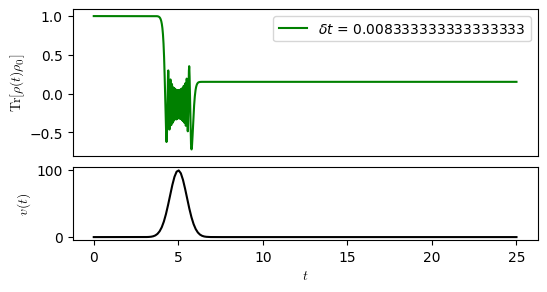

In [13]:
tf = 25
data_hi,trazas = dynamics(tf,sample = 3000)
times = np.linspace(0,tf,200)

# plot
fig, (ax,av) = plt.subplots(2,1,figsize = (6,3),gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0.1)
ax.plot(*data_hi, 'g-', alpha = 1, label = r'$\delta t$ = '+str(tf/len(data_hi[0])))
ax.set_ylabel(r'$\mathrm{Tr}[\rho(t)\rho_0]$', usetex=True, fontsize = 10)
ax.set_xticks([])
av.set_xlabel(r'$t$', usetex = True, fontsize = 10)
av.plot(times, pulso_gaussiano(times),'k-');
av.set_ylabel(r'$v(t)$', usetex = True,fontsize = 10);
ax.legend()

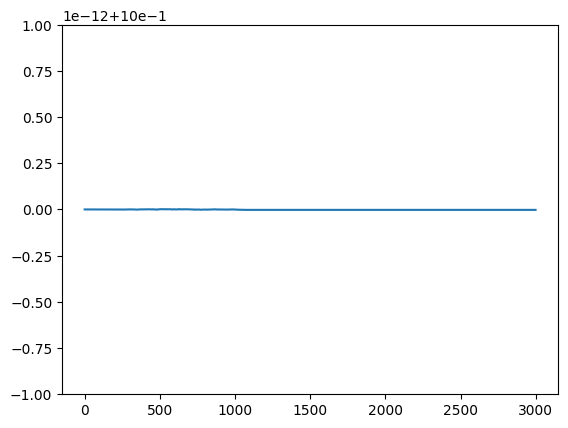

In [14]:
plt.plot(np.real(trazas))

In [15]:
trazas

[1.0,
 (1+3.453555500029093e-66j),
 (1-7.418412301374843e-68j),
 (1-8.071232583895829e-65j),
 (1-3.2284930335583316e-64j),
 (1-7.596454196607839e-64j),
 (1-1.2154326714572542e-63j),
 (1-1.2154326714572542e-63j),
 (1-3.0385816786431356e-63j),
 (1-4.861730685829017e-63j),
 (1-2.4308653429145085e-63j),
 (1-2.4308653429145085e-63j),
 (1+6.684879693014898e-63j),
 (1+8.50802870020078e-63j),
 (1+1.458519205748705e-62j),
 (1+1.9446922743316068e-62j),
 (1+0j),
 (1+0j),
 (1+3.8893845486632136e-62j),
 (1-3.8893845486632136e-62j),
 (1+1.166815364598964e-61j),
 (1+1.5557538194652854e-61j),
 (1+3.111507638930571e-61j),
 (1-3.428962173846825e-100j),
 (1+1.0890276736256998e-60j),
 (1+2.4892061111444567e-60j),
 (1+4.2005353125562707e-60j),
 (1+2.4892061111444567e-60j),
 (1+2.800356875037514e-60j),
 (1+2.4892061111444567e-60j),
 (1+1.2446030555722283e-60j),
 (1+7.46761833343337e-60j),
 (1+9.956824444577827e-60j),
 (1+2.4892061111444567e-60j),
 (1+2.4892061111444567e-60j),
 (1+1.493523666686674e-59j),
 (